<a href="https://colab.research.google.com/github/lmoghimi/personal-processing/blob/main/xrd_phase_analysis_Lauren.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run these first

In [1]:
# Imports for JupyterLite
%pip install -q ipywidgets

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import heapq

# timestamps = ['primary-1', ]
shift = True            #
get_timestamps = True
#ntimestamps = 2 #for comparison between t0 and tf
ntimestamps = 125 #for all runs
#ntimestamps_depths
lw = 0.75 #linewidth
userdir = "/content/drive/Shareddrives/leoradm_group/NSLS-II_202403"
scriptdir = os.path.join(userdir, 'userScripts')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
#@title Peak positions for reference + save settings
wavelength = 0.1824 #angstrom
'''
ref_tth_fe = [5.205, 9.022, 7.364, 10.421, 11.656, 12.772, 13.801, 14.759] #2theta
ref_d_fe = 0.5*wavelength/np.sin(np.radians(np.divide(ref_tth_fe,2))) #conversion to d
ref_q_fe = 2*np.pi/ref_d_fe #conversion to q
'''
#ref_q_fe = [3.128, 5.419, 4.424, 6.995, 8.277, 6.257, 7.663]
#ref_q_fe = [3.128, 5.419, 4.424]
ref_q_fe = [3.128] #prominent isolated phase peak
#lincol_fe='tab:green' #iron
lincol_fe='tab:brown'

'''
ref_tth_w = [4.833, 6.837, 4.185, 8.019, 10.820, 8.376, 11.856, 10.545] #remove 3rd number if plot in tth
ref_d_w = 0.5*wavelength/np.sin(np.radians(np.divide(ref_tth_w,2)))
ref_q_w = 2*np.pi/ref_d_w
'''
#ref_q_w = [2.905, 4.108, 2.516, 4.817, 6.495, 5.031, 7.115, 6.331, 8.715, 8.593, 7.547, 8.216, 5.810]
#ref_q_w = [2.905, 4.108, 2.516]
ref_q_w = [4.108] #prominent isolated phase peak
#lincol_w='tab:red' #wustite
lincol_w='tab:pink'

'''
ref_tth_m = [4.145, 7.083, 6.520, 3.540, 9.639, 5.019, 6.143, 8.324, 10.846] #remove 1st one if plot in tth
ref_d_m = 0.5*wavelength/np.sin(np.radians(np.divide(ref_tth_m,2)))
ref_q_m = 2*np.pi/ref_d_m
'''
#ref_q_m = [2.4783, 2.5973, 4.2458, 3.8889, 2.1214, 2.9982, 5.7584, 3.6680, 1.2887, 4.9086]
#ref_q_m = [2.4783, 2.5973, 4.2458]
ref_q_m = [2.1214] #prominent isolated phase peak
#lincol_m='tab:purple' #magnetite
lincol_m='tab:green'

'''
ref_tth_h = [3.870, 4.150, 6.167, 5.675, 7.033, 7.190, 2.837, 7.973] #remove 2nd number if plot in tth
ref_d_h = 0.5*wavelength/np.sin(np.radians(np.divide(ref_tth_h,2)))
ref_q_h = 2*np.pi/ref_d_h
'''
#ref_q_h = [2.4985, 2.3135, 3.7118, 4.3288, 3.41365, 4.2259, 1.6965, 2.8481, 4.8017, 3.92775, 4.9868, 5.6860, 5.5009, 5.9533, 6.5394]
#ref_q_h = [2.4985, 2.3135, 3.7118]
ref_q_h = [2.3135] #prominent isolated phase peak
#lincol_h='tab:orange' #hematite
lincol_h='tab:cyan'

lincol_h_ore = 'tab:purple'

lincol_magh='tab:olive' #maghemite

lincol_qz = 'tab:gray' #quartz

#lincol_wf = 'tab:blue' #sets the line color for the waterfall series
#lincol_wf = 'navy'

#Would you like to save the plots? Enter y/n
response = "n" ##### at some point it would be nice to make this pop up as a prompt so that we don't forget to change the response
xrd_type = "q" ##### d or tth or q. also make this pop up as a prompt

In [5]:
def f(x):
  return x

interact(f, x=10)


interactive(children=(IntSlider(value=10, description='x', max=30, min=-10), Output()), _dom_classes=('widget-…

<function __main__.f(x)>

In [65]:
#@title Loading data files
for run in ['run64']:
    ntimestamps = 15 ##########change later

    ###################### parsing the filename
    tiffdir = os.path.join(userdir, 'tiff_base')
    # print(userdir, tiffdir)
    runslist = glob.glob(tiffdir + '/*')
    # print(runslist)
    runsdict = {}
    for run_item in runslist:
        run_number = os.path.basename(run_item).split('_')[0]
        runsdict[run_number] = run_item
    # print(runsdict)

    file_pattern = os.path.join(runsdict[run], 'integration', '*_mean_q.chi')
    expname = os.path.basename(runsdict[run])
    # print(file_pattern)
    filelist = glob.glob(file_pattern)
    # print(filelist)
    filedict = {}
    for filename in filelist:
        file_parse = os.path.basename(filename).split('_')
        if not ('ss' in file_parse or 'stg2' in file_parse):
            file_number = file_parse[-3] # this takes the primary number
            filedict[file_number] = filename

    ################# grab ntimestamps curves (equally spacing in time)
    if get_timestamps:
        timestamps = ['primary-%d'%k for k in np.linspace(1, len(filedict)-1, ntimestamps).astype(int)]

    raw_data_save_all = []

    print('ntimestamps =', ntimestamps)
    for iv, timestamp in enumerate(timestamps):
        timestamp_num = int(timestamp.split('-')[-1]) # convert timestamp string to number
        filename = filedict[timestamp]
        '''
        print()
        print('Loading file', filename)
        '''
        ##print('Scan # ', timestamp_num)
        rawdata = np.loadtxt(filename) #each rawdata is [(#data, 2)], where 2 represents q and I columns
        raw_data_save_all.append(rawdata)
        '''
        q = rawdata[:, 0]
        I = rawdata[:, 1]
        I = I - I.min() #"baselining" the data
        '''
    ##### convert raw data_save_all into numpy array ######
    raw_data_save_all = np.array(raw_data_save_all) #stacks the array  #makes 3D array of 125, q and I for each run --> (nstimestamps, nt, 2)
    print('shape of array is = ', raw_data_save_all.shape)

ntimestamps = 15
shape of array is =  (15, 3000, 2)


interactive(children=(IntRangeSlider(value=(880, 915), description='I_fe_range', max=3000), FloatSlider(value=…

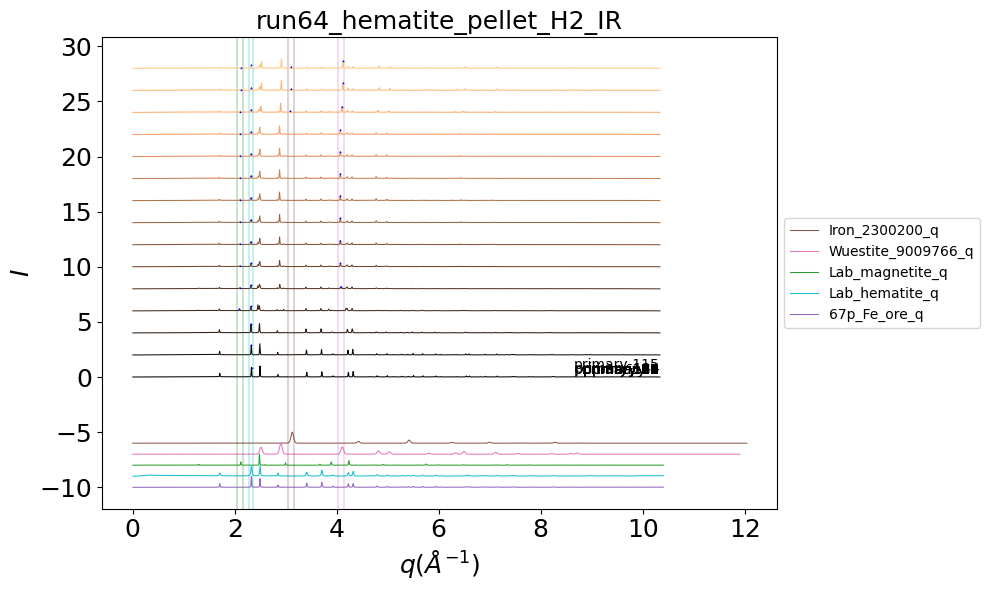

In [77]:
#@title Defining the function for interactive plotting
## create figure object -- plotting setting ##
#figsize = (12, 6)
figsize = (10, 6)
fs = 18
fig, ax = plt.subplots(figsize=figsize, tight_layout=True)

######### load multiple reference files, Yifan, 2024/4/12
ref_phases = ['Iron_2300200_q', 'Wuestite_9009766_q','Lab_magnetite_q','Lab_hematite_q','67p_Fe_ore_q']
color_ref_phases = [lincol_fe, lincol_w, lincol_m, lincol_h, lincol_h_ore]
ref_shift_y = -1
for i_phase, ref_phase in enumerate(ref_phases):
    reffile = os.path.join(userdir, 'userScripts', 'xrd_profiles', ref_phase + '.txt')
    refdata = np.loadtxt(reffile)
    q_ref = refdata[:, 0]
    I_ref = refdata[:, 1]
    I_ref = I_ref - I_ref.min() #"baselining" the data
    sensitivity = 500 #the larger the value, the more prominent the peaks
    #I_ref = I_ref/(I_ref.max()/sensitivity)  + ref_shift_y*(i_phase + 1) -200
    I_ref = I_ref/(I_ref.max())  + ref_shift_y*(i_phase + 1) -5
    ax.plot(q_ref, I_ref, label= ref_phase, linewidth= lw, color= color_ref_phases[i_phase])

    ax.set_xlabel(r'$q  ({\AA}^{-1})$', fontsize=fs)
    ax.set_ylabel(r'$I$', fontsize=fs)
    ax.set_title(expname, fontsize=fs)
    ax.tick_params(labelsize=fs)

    ax.legend(loc='center left', bbox_to_anchor=[1, 0.5])

##plot display for markers and reference lines
lw_fp = 0.025 #linewidth for find_peaks range
markersz = .5 #define marker size for results of find_peaks
#markersh = 'x' #define marker shape
markersh = 'v'
marcol_fe = 'b'
marcol_h = 'b'
marcol_w = 'b'
marcol_m = 'b'
'''
marcol_fe = 'tab:purple'
marcol_h = 'tab:orange'
marcol_w = 'tab:red'
marcol_m = 'tab:green'
'''
mark_dist = 0 #marker vertical distance from peak

## here we want to define 8 sets of inputs: 4 scrollbars to define the range for each phase peak, 4 inputs for the prominence of each phase peak
@interact(I_fe_range=widgets.IntRangeSlider(value=[880,915], min=0, max=raw_data_save_all.shape[1]),
          prominence_fe=widgets.FloatSlider(value=0.075, min=0, max=1, step=0.005), #prominence_fe = 1.5 #prominence_fe = .1
          I_w_range=widgets.IntRangeSlider(value=[1165,1200], min=0, max=raw_data_save_all.shape[1]),
          prominence_w=widgets.FloatSlider(value=0.05, min=0, max=1, step=0.005),
          I_m_range=widgets.IntRangeSlider(value=[590,625], min=0, max=raw_data_save_all.shape[1]),
          prominence_m=widgets.FloatSlider(value=0.05, min=0, max=1, step=0.005),
          I_h_range=widgets.IntRangeSlider(value=[660,680], min=0, max=raw_data_save_all.shape[1]),
          prominence_h=widgets.FloatSlider(value=0.05, min=0, max=1, step=0.005),
         )
def plotting_peak_fit(I_fe_range, prominence_fe,
          I_w_range, prominence_w,
          I_m_range, prominence_m,
          I_h_range, prominence_h):
    I_fe_low, I_fe_up = tuple(I_fe_range)
    I_w_low, I_w_up = tuple(I_w_range)
    I_m_low, I_m_up = tuple(I_m_range)
    I_h_low, I_h_up = tuple(I_h_range)

    ################# plotting setting #####################################################################################
    # figsize = (10, 6)
    # fs = 18
    # fig, ax = plt.subplots(figsize=figsize, tight_layout=True) #this is key for "hold on"!!!!
    # ax.clear()

    num_of_lines = len(timestamps)
    lincol_gradient = iter(cm.copper(np.linspace(0,1,num_of_lines))) #Wistia, copper, and autumn are nice gradients
    counting = 0

    ################ plotting selected timestamps and finding peaks ########################################################
    find_peak_outputs = []
    for iv, timestamp in enumerate(timestamps):
        timestamp_num = int(timestamp.split('-')[-1]) # convert timestamp string to number
        filename = filedict[timestamp]
        rawdata = raw_data_save_all[iv, :, :]
        q = rawdata[:, 0]
        I = rawdata[:, 1]
        I = I - I.min() #"baselining" the data
        #I = I - I[2350]
        '''
        #I = I + iv * 300
        #I = I + iv * 100 #iv is basically the index number for the scan. this makes a waterfall plot
        # I = I/I.max() + 0.25 * iv
        '''

        if timestamp == 'primary-1':
          print('This is the first file')
          #I0 = I
          I0 = I.copy() #fix I0!!!!!!!!!!!!!!!!!!!!!!!!!
          I_treated = I0/I0.max()
        else:
          #print('not the first file...')
          #I_treated = I/I0
          I_treated = I/I0.max()
          #I = I + iv * 5 #only for visualizing, not for peak finding

        ###### plot waterfall data ########################################
        c=next(lincol_gradient)
        #ax.plot(q, I, color = c, linewidth = lw)
        wf_shift = iv*2
        ax.plot(q, I_treated + wf_shift, color = c, linewidth = lw) #here, Lauren!
        ax.text(q[-1], I[-1], timestamp, ha='right', va='bottom')

        counting = counting + 1

        ####### find peaks ######################################################

        #see where the peak range should be, for given input index
        ax.axvline(x=q[I_fe_low], linestyle='solid', linewidth = lw_fp, color=lincol_fe)
        ax.axvline(x=q[I_fe_up], linestyle='solid', linewidth = lw_fp, color=lincol_fe)
        ax.axvline(x=q[I_w_low], linestyle='solid', linewidth = lw_fp, color=lincol_w)
        ax.axvline(x=q[I_w_up], linestyle='solid', linewidth = lw_fp, color=lincol_w)
        ax.axvline(x=q[I_m_low], linestyle='solid', linewidth = lw_fp, color=lincol_m)
        ax.axvline(x=q[I_m_up], linestyle='solid', linewidth = lw_fp, color=lincol_m)
        ax.axvline(x=q[I_h_low], linestyle='solid', linewidth = lw_fp, color=lincol_h)
        ax.axvline(x=q[I_h_up], linestyle='solid', linewidth = lw_fp, color=lincol_h)

        #ax.axhline(y=prominence_fe, linestyle='solid', linewidth = .1, color=lincol_fe)
        ##ax.axhline(y=prominence_w, linestyle='solid', linewidth = .1, color=lincol_w)
        ##ax.axhline(y=prominence_m, linestyle='solid', linewidth = .1, color=lincol_m)
        ##ax.axhline(y=prominence_h, linestyle='solid', linewidth = .1, color=lincol_h)

        I_fe = I_treated[I_fe_low:I_fe_up] #define index of range within q to find peaks
        I_w = I_treated[I_w_low:I_w_up]
        I_m = I_treated[I_m_low:I_m_up]
        I_h = I_treated[I_h_low:I_h_up]

        num_phases = ['fe', 'w', 'm', 'h']
        for iii in num_phases: #repeat this process for each phase
          #print('iii = ', iii)
          ############for iron#############################
          if iii == num_phases[0]: #iron
            peaks, properties = find_peaks(I_fe, prominence_fe)
            #print(peaks, properties)
            #print('Index of peak in x that satisfy all given conditions: ', peaks)
            #print('Peak height: ', properties['peak_heights'])

            if peaks.size > 0: #i.e. if the list isn't empty --> if a peak was found
              val1_fe = q[(I_fe_low + peaks)][0] #there should only be one peak identified by find_peaks if the proper range was selected, so selecting the first value of the array should really be the only value
              val2_fe = I_treated[(I_fe_low + peaks)][0]
              ##print('Fe peak is located at q = ', val1_fe, ' with I_treated = ', val2_fe)

              ax.plot(val1_fe, val2_fe + wf_shift + mark_dist, color = marcol_fe, marker=markersh, markersize = markersz)

            else:
              ##print('List is empty. No peaks found in the specified range')
              val1_fe = float('nan')
              val2_fe = 0 #set intensity equal to zero if no peak is found

          ############for hematite#############################
          if iii == num_phases[3]: #hematite
            peaks, properties = find_peaks(I_h, prominence_h)
            #print(peaks, properties)
            #print('Index of peak in x that satisfy all given conditions: ', peaks)
            #print('Peak height: ', properties['peak_heights'])

            if peaks.size > 0:
              val1_h = q[(I_h_low + peaks)][0]
              val2_h = I_treated[(I_h_low + peaks)][0]
              ##print('H peak is located at q = ', val1_h, ' with I_treated = ', val2_h)

              ax.plot(val1_h, val2_h + wf_shift + mark_dist, color = marcol_h, marker=markersh, markersize = markersz)

            else:
              ##print('List is empty. No peaks found in the specified range')
              val1_h = float('nan')
              val2_h = 0

          ############for wustite#############################
          if iii == num_phases[1]: #wustite
            peaks, properties = find_peaks(I_w, prominence_w)
            #print(peaks, properties)
            #print('Index of peak in x that satisfy all given conditions: ', peaks)
            #print('Peak height: ', properties['peak_heights'])

            if peaks.size > 0:
              val1_w = q[(I_w_low + peaks)][0]
              val2_w = I_treated[(I_w_low + peaks)][0]
              ##print('W peak is located at q = ', val1_w, ' with I_treated = ', val2_w)

              ax.plot(val1_w, val2_w + wf_shift + mark_dist, color = marcol_w, marker=markersh, markersize = markersz)

            else:
              ##print('List is empty. No peaks found in the specified range')
              val1_w = float('nan')
              val2_w = 0

          ############for magnetite#############################
          if iii == num_phases[2]: #magnetite
            peaks, properties = find_peaks(I_m, prominence_m)
            #print(peaks, properties)
            #print('Index of peak in x that satisfy all given conditions: ', peaks)
            #print('Peak height: ', properties['peak_heights'])

            if peaks.size > 0:
              val1_m = q[(I_m_low + peaks)][0]
              val2_m = I_treated[(I_m_low + peaks)][0]
              ##print('M peak is located at q = ', val1_m, ' with I_treated = ', val2_m)

              ax.plot(val1_m, val2_m + wf_shift + mark_dist, color = marcol_m, marker=markersh, markersize = markersz)

            else:
              ##print('List is empty. No peaks found in the specified range')
              val1_m = float('nan')
              val2_m = 0

        #set the values here for this one timestamp
        item = {'Scan#': timestamp_num,
                'Fe': [val1_fe, val2_fe],
                'H': [val1_h, val2_h],
                'W': [val1_w, val2_w],
                'M': [val1_m, val2_m]
                }
        find_peak_outputs.append(item)

    #print('find_peak_outputs = ', find_peak_outputs) #now that we've finished "for iv, timestamp in enumerate(timestamps)"


Loading file /content/drive/Shareddrives/leoradm_group/NSLS-II_202403/tiff_base/run64_hematite_pellet_H2_IR/integration/run64_hematite_pellet_H2_IR_20240328-230456_e69f12_primary-1_mean_q.chi
This is the first file

Loading file /content/drive/Shareddrives/leoradm_group/NSLS-II_202403/tiff_base/run64_hematite_pellet_H2_IR/integration/run64_hematite_pellet_H2_IR_20240328-230456_e69f12_primary-1_mean_q.chi
This is the first file

Loading file /content/drive/Shareddrives/leoradm_group/NSLS-II_202403/tiff_base/run64_hematite_pellet_H2_IR/integration/run64_hematite_pellet_H2_IR_20240328-230456_e69f12_primary-2_mean_q.chi

Loading file /content/drive/Shareddrives/leoradm_group/NSLS-II_202403/tiff_base/run64_hematite_pellet_H2_IR/integration/run64_hematite_pellet_H2_IR_20240328-230456_e69f12_primary-3_mean_q.chi

Loading file /content/drive/Shareddrives/leoradm_group/NSLS-II_202403/tiff_base/run64_hematite_pellet_H2_IR/integration/run64_hematite_pellet_H2_IR_20240328-230456_e69f12_primary-4_

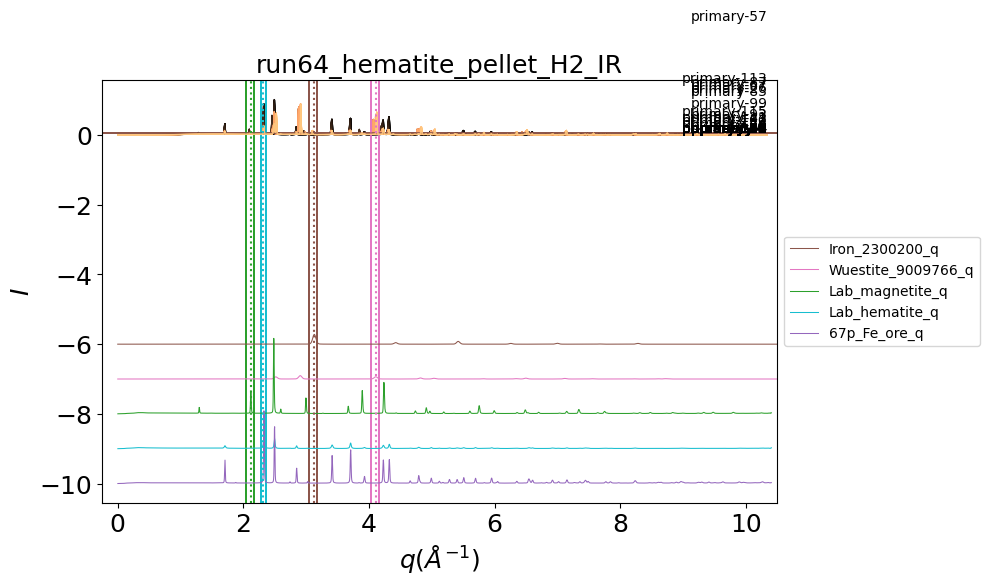

x =  [1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124]
y_fe =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.11375783796162074, 0.12631070444524833, 0.12990366078598764, 0.1269796812126177, 0.1320333979647092, 0.1292491344815801, 0.13120885065902083, 0.136009

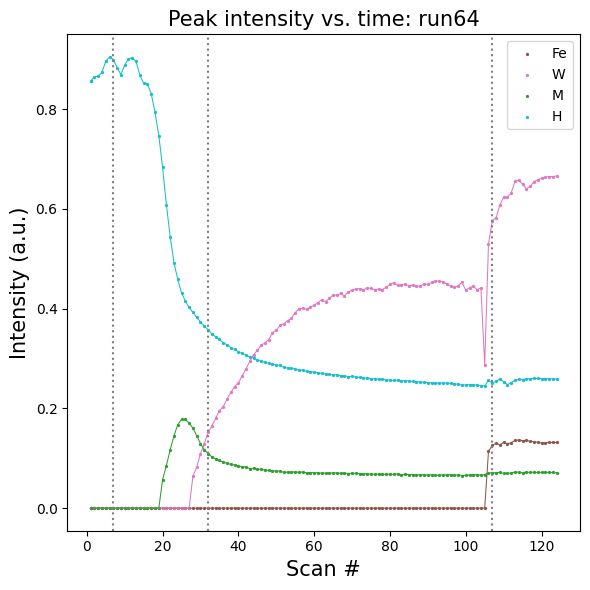

In [79]:
#@title Tracking peak position with time (multiple phases)
from scipy.signal import find_peaks
for run in ['run64']:
    ntimestamps = 125 ##########change later

    ###################### parsing the filename
    tiffdir = os.path.join(userdir, 'tiff_base')
    # print(userdir, tiffdir)
    runslist = glob.glob(tiffdir + '/*')
    # print(runslist)
    runsdict = {}
    for run_item in runslist:
        run_number = os.path.basename(run_item).split('_')[0]
        runsdict[run_number] = run_item
    # print(runsdict)

    file_pattern = os.path.join(runsdict[run], 'integration', '*_mean_q.chi')
    expname = os.path.basename(runsdict[run])
    # print(file_pattern)
    filelist = glob.glob(file_pattern)
    # print(filelist)
    filedict = {}
    for filename in filelist:
        file_parse = os.path.basename(filename).split('_')
        if not ('ss' in file_parse or 'stg2' in file_parse):
            file_number = file_parse[-3] # this takes the primary number
            filedict[file_number] = filename

    ################# grab ntimestamps curves (equally spacing in time)
    if get_timestamps:
        timestamps = ['primary-%d'%k for k in np.linspace(1, len(filedict)-1, ntimestamps).astype(int)]

    ################# plotting setting
    #figsize = (12, 6)
    figsize = (10, 6)
    fs = 18
    fig, ax = plt.subplots(figsize=figsize, tight_layout=True) #this is key for "hold on"!!!!

    num_of_lines = len(timestamps)
    lincol_gradient = iter(cm.copper(np.linspace(0,1,num_of_lines))) #Wistia, copper, and autumn are nice gradients
    counting = 0
    ################ plotting selected timestamps and finding peaks
    find_peak_outputs = []
    for iv, timestamp in enumerate(timestamps):
        timestamp_num = int(timestamp.split('-')[-1]) # convert timestamp string to number
        filename = filedict[timestamp]
        print()
        print('Loading file', filename)
        ##print('Scan # ', timestamp_num)
        rawdata = np.loadtxt(filename)
        q = rawdata[:, 0]
        I = rawdata[:, 1]
        I = I - I.min() #"baselining" the data
        #I = I - I[2350]
        '''
        #I = I + iv * 300
        #I = I + iv * 100 #iv is basically the index number for the scan. this makes a waterfall plot
        # I = I/I.max() + 0.25 * iv
        '''

        if timestamp == 'primary-1':
          print('This is the first file')
          #I0 = I
          I0 = I.copy() #fix I0!!!!!!!!!!!!!!!!!!!!!!!!!
          I_treated = I0/I0.max()
        else:
          #print('not the first file...')
          #I_treated = I/I0
          I_treated = I/I0.max()
          #I = I + iv * 5 #only for visualizing, not for peak finding

        ###### plot waterfall data ########################################
        c=next(lincol_gradient)
        #ax.plot(q, I, color = c, linewidth = lw)
        ax.plot(q, I_treated, color = c, linewidth = lw)
        ax.text(q[-1], I[-1], timestamp, ha='right', va='bottom')

        counting = counting + 1

        ####### find peaks ######################################################
        #scipy.signal.find_peaks(x, height=None, threshold=None, distance=None, prominence=None, width=None, wlen=None, rel_height=0.5, plateau_size=None)
        #range and prominence for peak finding
        I_fe_low = 880
        I_fe_up = 915
        #prominence_fe = 1.5
        #prominence_fe = .1
        prominence_fe = .075
        I_w_low = 1165
        I_w_up = 1200
        prominence_w = .05
        I_m_low = 590
        I_m_up = 625
        prominence_m = .05
        I_h_low = 660
        I_h_up = 680
        prominence_h = .05

        #see where the peak range should be, for given input index
        plt.axvline(x=q[I_fe_low], linestyle='solid', linewidth = .1, color=lincol_fe)
        plt.axvline(x=q[I_fe_up], linestyle='solid', linewidth = .1, color=lincol_fe)
        plt.axvline(x=q[I_w_low], linestyle='solid', linewidth = .1, color=lincol_w)
        plt.axvline(x=q[I_w_up], linestyle='solid', linewidth = .1, color=lincol_w)
        plt.axvline(x=q[I_m_low], linestyle='solid', linewidth = .1, color=lincol_m)
        plt.axvline(x=q[I_m_up], linestyle='solid', linewidth = .1, color=lincol_m)
        plt.axvline(x=q[I_h_low], linestyle='solid', linewidth = .1, color=lincol_h)
        plt.axvline(x=q[I_h_up], linestyle='solid', linewidth = .1, color=lincol_h)

        plt.axhline(y=prominence_fe, linestyle='solid', linewidth = .1, color=lincol_fe)
        ##plt.axhline(y=prominence_w, linestyle='solid', linewidth = .1, color=lincol_w)
        ##plt.axhline(y=prominence_m, linestyle='solid', linewidth = .1, color=lincol_m)
        ##plt.axhline(y=prominence_h, linestyle='solid', linewidth = .1, color=lincol_h)

        I_fe = I_treated[I_fe_low:I_fe_up] #define index of range within q to find peaks
        I_w = I_treated[I_w_low:I_w_up]
        I_m = I_treated[I_m_low:I_m_up]
        I_h = I_treated[I_h_low:I_h_up]

        num_phases = ['fe', 'w', 'm', 'h']
        for iii in num_phases: #repeat this process for each phase
          #print('iii = ', iii)
          ############for iron#############################
          if iii == num_phases[0]: #iron
            peaks, properties = find_peaks(I_fe, prominence_fe)
            #print(peaks, properties)
            #print('Index of peak in x that satisfy all given conditions: ', peaks)
            #print('Peak height: ', properties['peak_heights'])

            if peaks.size > 0: #i.e. if the list isn't empty --> if a peak was found
              val1_fe = q[(I_fe_low + peaks)][0] #there should only be one peak identified by find_peaks if the proper range was selected, so selecting the first value of the array should really be the only value
              val2_fe = I_treated[(I_fe_low + peaks)][0]
              ##print('Fe peak is located at q = ', val1_fe, ' with I_treated = ', val2_fe)

            else:
              ##print('List is empty. No peaks found in the specified range')
              val1_fe = float('nan')
              val2_fe = 0 #set intensity equal to zero if no peak is found

          ############for hematite#############################
          if iii == num_phases[3]: #hematite
            peaks, properties = find_peaks(I_h, prominence_h)
            #print(peaks, properties)
            #print('Index of peak in x that satisfy all given conditions: ', peaks)
            #print('Peak height: ', properties['peak_heights'])

            if peaks.size > 0:
              val1_h = q[(I_h_low + peaks)][0]
              val2_h = I_treated[(I_h_low + peaks)][0]
              ##print('H peak is located at q = ', val1_h, ' with I_treated = ', val2_h)

            else:
              ##print('List is empty. No peaks found in the specified range')
              val1_h = float('nan')
              val2_h = 0

          ############for wustite#############################
          if iii == num_phases[1]: #wustite
            peaks, properties = find_peaks(I_w, prominence_w)
            #print(peaks, properties)
            #print('Index of peak in x that satisfy all given conditions: ', peaks)
            #print('Peak height: ', properties['peak_heights'])

            if peaks.size > 0:
              val1_w = q[(I_w_low + peaks)][0]
              val2_w = I_treated[(I_w_low + peaks)][0]
              ##print('W peak is located at q = ', val1_w, ' with I_treated = ', val2_w)

            else:
              ##print('List is empty. No peaks found in the specified range')
              val1_w = float('nan')
              val2_w = 0

          ############for magnetite#############################
          if iii == num_phases[2]: #magnetite
            peaks, properties = find_peaks(I_m, prominence_m)
            #print(peaks, properties)
            #print('Index of peak in x that satisfy all given conditions: ', peaks)
            #print('Peak height: ', properties['peak_heights'])

            if peaks.size > 0:
              val1_m = q[(I_m_low + peaks)][0]
              val2_m = I_treated[(I_m_low + peaks)][0]
              ##print('M peak is located at q = ', val1_m, ' with I_treated = ', val2_m)

            else:
              ##print('List is empty. No peaks found in the specified range')
              val1_m = float('nan')
              val2_m = 0


        #set the values here for this one timestamp
        item = {'Scan#': timestamp_num,
                'Fe': [val1_fe, val2_fe],
                'H': [val1_h, val2_h],
                'W': [val1_w, val2_w],
                'M': [val1_m, val2_m]
                }
        find_peak_outputs.append(item)
        #print('find_peak_outputs = ', find_peak_outputs)
    #
        #ok, now plot the result of find_peaks for this run, to make sure  ################
        #would like to create a movie for each frame, displaying in the output window but without saving the movie
        ################Yifan pls help with implementing this


    ######### load multiple reference files, Yifan, 2024/4/12
    ref_phases = ['Iron_2300200_q', 'Wuestite_9009766_q','Lab_magnetite_q','Lab_hematite_q','67p_Fe_ore_q']
    color_ref_phases = [lincol_fe, lincol_w, lincol_m, lincol_h, lincol_h_ore]
    ref_shift_y = -1
    for i_phase, ref_phase in enumerate(ref_phases):
        reffile = os.path.join(userdir, 'userScripts', 'xrd_profiles', ref_phase + '.txt')
        refdata = np.loadtxt(reffile)
        q_ref = refdata[:, 0]
        I_ref = refdata[:, 1]
        I_ref = I_ref - I_ref.min() #"baselining" the data
        sensitivity = 500 #the larger the value, the more prominent the peaks
        #I_ref = I_ref/(I_ref.max()/sensitivity)  + ref_shift_y*(i_phase + 1) -200
        I_ref = I_ref/(I0.max())  + ref_shift_y*(i_phase + 1) -5
        ax.plot(q_ref, I_ref, label= ref_phase, linewidth= lw, color= color_ref_phases[i_phase])


    xlim_left, xlim_right = -0.25, 10.5 #for q
    ax.set_xlim(xlim_left, xlim_right)
    ######## put the legend outside of the box, Yifan, 20240422 ############
    # ax.legend(loc='lower right')
    ax.legend(loc='center left', bbox_to_anchor=[1, 0.5])
    ########################################################################

    ax.set_xlabel(r'$q  ({\AA}^{-1})$', fontsize=fs)
    ax.set_ylabel(r'$I$', fontsize=fs)
    ax.set_title(expname, fontsize=fs)
    ax.tick_params(labelsize=fs)
    #ax.set_yticklabels([]) #turns off tick labels for vertical axis

################# plot vertical lines for the reference phase peaks

    for i_vert_line in ref_q_fe: #plot the vertical lines
        plt.axvline(x=i_vert_line, linestyle='dotted', color=lincol_fe)

    for i_vert_line in ref_q_w:
            plt.axvline(x=i_vert_line, linestyle='dotted', color=lincol_w)

    for i_vert_line in ref_q_m:
            plt.axvline(x=i_vert_line, linestyle='dotted', color=lincol_m)

    for i_vert_line in ref_q_h:
            plt.axvline(x=i_vert_line, linestyle='dotted', color=lincol_h)

 ########## save settings
    if response == "y":
      print("Saving the file...!")
      fname_typ = 'wf_'+ xrd_type + '_' + expname + '.png' #wf = waterfall
      save_loc = os.path.join(userdir, 'userAnalysis' + '/' + 'waterfallPlots'+ '/')
      if not os.path.isdir(save_loc):
          os.makedirs(save_loc)
      plt.savefig(save_loc + fname_typ)
    elif response == "n":
      print()
      print("Showing the plot without saving...")
      plt.show()
    else:
      print()
      print("Please enter yes or no.")

  ###### plot peak intensity vs time ##################################################
    x = []
    y_fe = []
    y_h = []
    y_w = []
    y_m = []
    '''
    print("find_peak_outputs = ", find_peak_outputs)
    print('timestamps = ', timestamps)
    print('ntimestamps = ', ntimestamps)
    print()
    '''
    for i, timestamp in enumerate(timestamps):
      timestamp_num = int(timestamp.split('-')[-1]) # convert timestamp string to number
      #print('timestamp_num = ', timestamp_num)
      index_request = i
      #print('index is =', index_request)
      if index_request > ntimestamps: #once we've gone through the full list of timestamps, break the for loop
        break
      else:
        #print("find_peak_outputs[index_request]['Scan#'] = ", find_peak_outputs[index_request]['Scan#'])
        scan = find_peak_outputs[index_request]['Scan#']
        inten_fe = find_peak_outputs[index_request]['Fe'][1] #second value in the array gives intensity
        inten_h = find_peak_outputs[index_request]['H'][1]
        inten_w = find_peak_outputs[index_request]['W'][1]
        inten_m = find_peak_outputs[index_request]['M'][1]
        x.append(scan)
        y_fe.append(inten_fe)
        y_h.append(inten_h)
        y_w.append(inten_w)
        y_m.append(inten_m)
      #print()
    print('x = ', x)
    print('y_fe = ', y_fe)
    print('y_h = ', y_h)
    print('y_w = ', y_w)
    print('y_m = ', y_m)

    thisfs = 15
    markersz = 7
    laserls = 'dotted'
    lasercol = 'tab:gray'
    fig, axx = plt.subplots(figsize=(6,6), tight_layout=True)
    axx.scatter(x, y_fe, color = lincol_fe, marker='.', s=markersz, label = 'Fe')
    axx.plot(x, y_fe, linewidth = lw, color = lincol_fe)
    axx.scatter(x, y_w, color = lincol_w, marker='.', s=markersz, label = 'W')
    axx.plot(x, y_w, linewidth = lw, color = lincol_w)
    axx.scatter(x, y_m, color = lincol_m, marker='.', s=markersz, label = 'M')
    axx.plot(x, y_m, linewidth = lw, color = lincol_m)
    axx.scatter(x, y_h, color = lincol_h, marker='.', s=markersz, label = 'H')
    axx.plot(x, y_h, linewidth = lw, color = lincol_h)

    ######## plotting the result of find_peaks for this run ################
    #would like to create a movie for each frame, displaying in the output window but without saving the movie
    ################Yifan pls help with implementing this


    ## manually mark when the laser turned on, reached max power, and turned off ##
    laser = [7, 32, 107] #run51
    #laser = [5, 30, 105] #run64
    for vi in laser:
      plt.axvline(x=vi, linestyle=laserls, color=lasercol)

    plt.legend(loc='upper right')
    axx.set_xlabel('Scan #', fontsize=thisfs)
    axx.set_ylabel('Intensity (a.u.)', fontsize=thisfs)
    plottit = 'Peak intensity vs. time: ' + expname.split('_')[0]
    axx.set_title(plottit, fontsize=thisfs)
    plt.show()
    #be sure to check that the range, prominence, etc still work with a larger dataset of 125 timestamps

In [ ]:
#@title Comparative phase analysis for t_final vs t_0
for run in ['run53']:

    ###################### parsing the filename
    tiffdir = os.path.join(userdir, 'tiff_base')
    # print(userdir, tiffdir)
    runslist = glob.glob(tiffdir + '/*')
    # print(runslist)
    runsdict = {}
    for run_item in runslist:
        run_number = os.path.basename(run_item).split('_')[0]
        runsdict[run_number] = run_item
    # print(runsdict)

    file_pattern = os.path.join(runsdict[run], 'integration', '*_mean_q.chi')
    expname = os.path.basename(runsdict[run])
    # print(file_pattern)
    filelist = glob.glob(file_pattern)
    # print(filelist)
    filedict = {}
    for filename in filelist:
        file_parse = os.path.basename(filename).split('_')
        if not ('ss' in file_parse or 'stg2' in file_parse):
            file_number = file_parse[-3] # this takes the primary number
            filedict[file_number] = filename

    ################# grab ntimestamps curves (equally spacing in time)
    if get_timestamps:
        timestamps = ['primary-%d'%k for k in np.linspace(1, len(filedict)-1, ntimestamps).astype(int)]

    ################# plotting setting
    #figsize = (12, 6)
    figsize = (10, 6)
    fs = 18
    fig, ax = plt.subplots(figsize=figsize, tight_layout=True) #this is key for "hold on"!!!!

    num_of_lines = len(timestamps)
    lincol_gradient = iter(cm.copper(np.linspace(0,1,num_of_lines))) #Wistia, copper, and autumn are nice gradients
    counting = 0
    ################ plotting selected timestamps
    for iv, timestamp in enumerate(timestamps):
        filename = filedict[timestamp]
        print('Loading file', filename)
        print(timestamp)
        rawdata = np.loadtxt(filename)
        q = rawdata[:, 0]
        I = rawdata[:, 1]
        I = I - I.min() #"baselining" the data
        '''
        #I = I + iv * 300
        #I = I + iv * 100 #iv is basically the index number for the scan. this makes a waterfall plot
        # I = I/I.max() + 0.25 * iv
        '''

        if timestamp == 'primary-1':
          print('This is the first file')
          #I0 = I
          I0 = I.copy() #fix I0!!!!!!!!!!!!!!!!!!!!!!!!!
          I = I0/I0.max() #plot the t0 data normalized by its max intensity
        else:
          print('not the first file...normalizing by I0')
          I = I/I0
          #I = I + iv * 5 #plot the tf data divided by the t0 data


        c=next(lincol_gradient)
        ax.plot(q, I, color = c, linewidth = lw)
        ax.text(q[-1], I[-1], timestamp, ha='right', va='bottom')

        counting = counting + 1

    ######### load multiple reference files, Yifan, 2024/4/12
    #ref_phases = ['SU_55Fe_S3_20231113-123848_ffaed2_primary-1_mean_q','SU_Lmag_S1_20231113-123625_d9ddff_primary-1_mean_q','SU_Lhem_S2_20231113-123737_848648_primary-1_mean_q','SU_67p1Fe_S6_20231113-124225_d3d593_primary-1_mean_q']
    #ref_phases = ['Iron_2300200', 'Wuestite_9009766','Magnetite_1528612','Hematite_1011240']
    ref_phases = ['Iron_2300200_q', 'Wuestite_9009766_q','Lab_magnetite_q','Lab_hematite_q','67p_Fe_ore_q']
    #ref_phases = ['Iron_2300200', 'Wuestite_9009766','Magnetite_1528612','Hematite_1011240','Maghemite_9006316']
    #color_ref_phases = [lincol_fe, lincol_m, lincol_h, lincol_h_ore] #setting the line colors for the reference files. these are predetermined in the previous code cell
    #color_ref_phases = [lincol_fe, lincol_w, lincol_m, lincol_h]
    color_ref_phases = [lincol_fe, lincol_w, lincol_m, lincol_h, lincol_h_ore]
    ref_shift_y = -1
    for i_phase, ref_phase in enumerate(ref_phases):
        reffile = os.path.join(userdir, 'userScripts', 'xrd_profiles', ref_phase + '.txt')
        refdata = np.loadtxt(reffile)
        q_ref = refdata[:, 0]
        #I_ref = (refdata[:, 1] - refdata[0, 1]) #"grounding" the data
        I_ref = refdata[:, 1]
        I_ref = I_ref - I_ref.min() #"baselining" the data
        sensitivity = 500 #the larger the value, the more prominent the peaks
        #I_ref = I_ref/(I_ref.max()/sensitivity)  + ref_shift_y*(i_phase + 1) -200
        I_ref = I_ref/(I0.max())  + ref_shift_y*(i_phase + 1) -5
        ax.plot(q_ref, I_ref, label= ref_phase, linewidth= lw, color= color_ref_phases[i_phase])


    xlim_left, xlim_right = -0.25, 10.5 #for q
    ax.set_xlim(xlim_left, xlim_right)
    ######## put the legend outside of the box, Yifan, 20240422 ############
    # ax.legend(loc='lower right')
    ax.legend(loc='center left', bbox_to_anchor=[1, 0.5])
    ########################################################################

    ax.set_xlabel(r'$q  ({\AA}^{-1})$', fontsize=fs)
    ax.set_ylabel(r'$I$', fontsize=fs)
    ax.set_title(expname, fontsize=fs)
    ax.tick_params(labelsize=fs)
    #ax.set_yticklabels([]) #turns off tick labels for vertical axis

################# plot vertical lines for the reference phase peaks
    for i_vert_line in ref_q_fe: #plot the vertical lines
        plt.axvline(x=i_vert_line, linestyle='dotted', color=lincol_fe)

    for i_vert_line in ref_q_w:
            plt.axvline(x=i_vert_line, linestyle='dotted', color=lincol_w)

    for i_vert_line in ref_q_m:
            plt.axvline(x=i_vert_line, linestyle='dotted', color=lincol_m)

    for i_vert_line in ref_q_h:
            plt.axvline(x=i_vert_line, linestyle='dotted', color=lincol_h)

 ########## save settings
    if response == "y":
      print("Saving the file...!")
      fname_typ = 'wf_'+ xrd_type + '_' + expname + '.png' #wf = waterfall
      save_loc = os.path.join(userdir, 'userAnalysis' + '/' + 'waterfallPlots'+ '/')
      if not os.path.isdir(save_loc):
          os.makedirs(save_loc)
      plt.savefig(save_loc + fname_typ)
    elif response == "n":
      print("Showing the plot without saving...")
      plt.show()
    else: print("Please enter yes or no.")

KeyboardInterrupt: 


Loading file /content/drive/Shareddrives/leoradm_group/NSLS-II_202403/tiff_base/run51_hematite_pellet_H2_blue_take3/integration/run51_hematite_pellet_H2_blue_take3_20240328-161448_1894cd_primary-1_mean_q.chi
Scan #  1
This is the first file
List is empty. No peaks found in the specified range

Loading file /content/drive/Shareddrives/leoradm_group/NSLS-II_202403/tiff_base/run51_hematite_pellet_H2_blue_take3/integration/run51_hematite_pellet_H2_blue_take3_20240328-161448_1894cd_primary-31_mean_q.chi
Scan #  31
List is empty. No peaks found in the specified range

Loading file /content/drive/Shareddrives/leoradm_group/NSLS-II_202403/tiff_base/run51_hematite_pellet_H2_blue_take3/integration/run51_hematite_pellet_H2_blue_take3_20240328-161448_1894cd_primary-62_mean_q.chi
Scan #  62
List is empty. No peaks found in the specified range

Loading file /content/drive/Shareddrives/leoradm_group/NSLS-II_202403/tiff_base/run51_hematite_pellet_H2_blue_take3/integration/run51_hematite_pellet_H2_blu

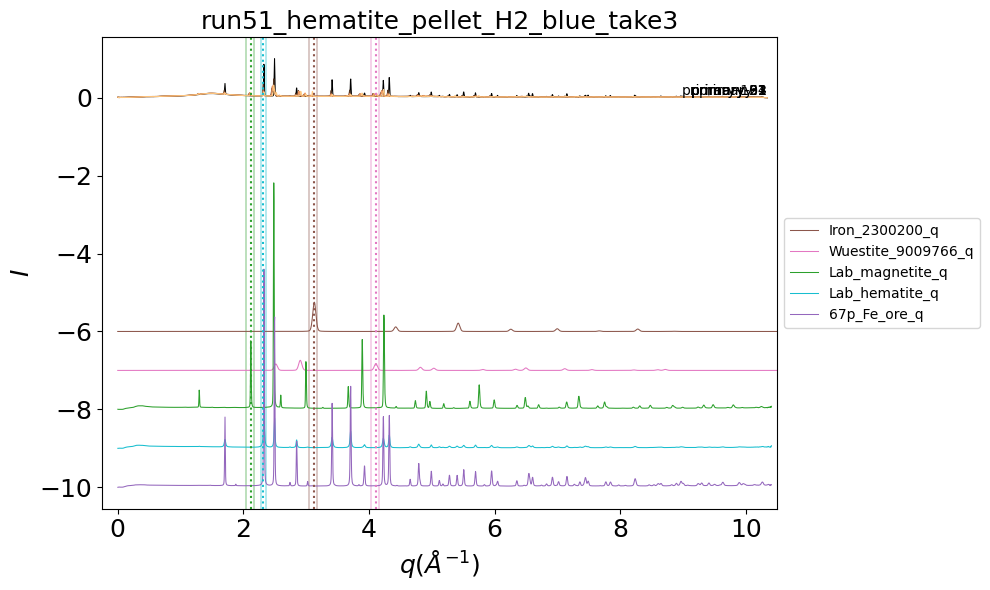

x =  [1, 31, 62, 93, 124]
y =  [0, 0, 0, 0, 0.16183256322274886]


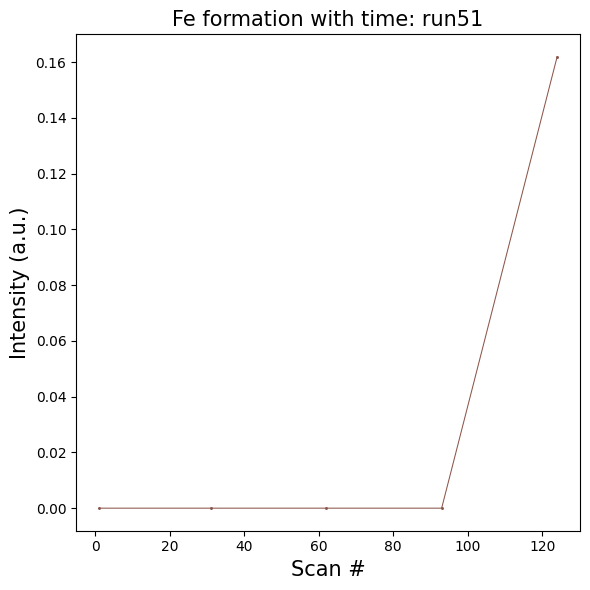

In [ ]:
#@title Tracking peak position with time (one phase)
from scipy.signal import find_peaks
for run in ['run51']:
    ntimestamps = 5 ##########change later

    ###################### parsing the filename
    tiffdir = os.path.join(userdir, 'tiff_base')
    # print(userdir, tiffdir)
    runslist = glob.glob(tiffdir + '/*')
    # print(runslist)
    runsdict = {}
    for run_item in runslist:
        run_number = os.path.basename(run_item).split('_')[0]
        runsdict[run_number] = run_item
    # print(runsdict)

    file_pattern = os.path.join(runsdict[run], 'integration', '*_mean_q.chi')
    expname = os.path.basename(runsdict[run])
    # print(file_pattern)
    filelist = glob.glob(file_pattern)
    # print(filelist)
    filedict = {}
    for filename in filelist:
        file_parse = os.path.basename(filename).split('_')
        if not ('ss' in file_parse or 'stg2' in file_parse):
            file_number = file_parse[-3] # this takes the primary number
            filedict[file_number] = filename

    ################# grab ntimestamps curves (equally spacing in time)
    if get_timestamps:
        timestamps = ['primary-%d'%k for k in np.linspace(1, len(filedict)-1, ntimestamps).astype(int)]

    ################# plotting setting
    #figsize = (12, 6)
    figsize = (10, 6)
    fs = 18
    fig, ax = plt.subplots(figsize=figsize, tight_layout=True) #this is key for "hold on"!!!!

    num_of_lines = len(timestamps)
    lincol_gradient = iter(cm.copper(np.linspace(0,1,num_of_lines))) #Wistia, copper, and autumn are nice gradients
    counting = 0
    ################ plotting selected timestamps and finding peaks
    find_peak_outputs = []
    for iv, timestamp in enumerate(timestamps):
        timestamp_num = int(timestamp.split('-')[-1]) # convert timestamp string to number
        filename = filedict[timestamp]
        print()
        print('Loading file', filename)
        print('Scan # ', timestamp_num)
        rawdata = np.loadtxt(filename)
        q = rawdata[:, 0]
        I = rawdata[:, 1]
        I = I - I.min() #"baselining" the data
        #I = I - I[2350]
        '''
        #I = I + iv * 300
        #I = I + iv * 100 #iv is basically the index number for the scan. this makes a waterfall plot
        # I = I/I.max() + 0.25 * iv
        '''

        if timestamp == 'primary-1':
          print('This is the first file')
          #I0 = I
          I0 = I.copy() #fix I0!!!!!!!!!!!!!!!!!!!!!!!!!
          I_treated = I0/I0.max()
        else:
          #print('not the first file...')
          #I_treated = I/I0
          I_treated = I/I0.max()
          #I = I + iv * 5 #only for visualizing, not for peak finding

        ###### plot waterfall data ########################################
        c=next(lincol_gradient)
        #ax.plot(q, I, color = c, linewidth = lw)
        ax.plot(q, I_treated, color = c, linewidth = lw)
        ax.text(q[-1], I[-1], timestamp, ha='right', va='bottom')

        counting = counting + 1

        ####### find peaks ######################################################
        #find where the peak range should be, for given input index
        plt.axvline(x=q[880], linestyle='solid', linewidth = .1, color=lincol_fe)
        plt.axvline(x=q[915], linestyle='solid', linewidth = .1, color=lincol_fe)
        plt.axvline(x=q[1165], linestyle='solid', linewidth = .1, color=lincol_w)
        plt.axvline(x=q[1200], linestyle='solid', linewidth = .1, color=lincol_w)
        plt.axvline(x=q[590], linestyle='solid', linewidth = .1, color=lincol_m)
        plt.axvline(x=q[625], linestyle='solid', linewidth = .1, color=lincol_m)
        plt.axvline(x=q[660], linestyle='solid', linewidth = .1, color=lincol_h)
        plt.axvline(x=q[680], linestyle='solid', linewidth = .1, color=lincol_h)

        #find peaks
        #scipy.signal.find_peaks(x, height=None, threshold=None, distance=None, prominence=None, width=None, wlen=None, rel_height=0.5, plateau_size=None)

        #range and prominence for peak finding
        I_fe_low = 880
        I_fe_up = 915
        #prominence_fe = 1.5
        #prominence_fe = .1
        prominence_fe = .075
        I_w_low = 1165
        I_w_up = 1200
        I_m_low = 590
        I_m_up = 625
        I_h_low = 660
        I_h_up = 680
        prominence_h = .075

        I_fe = I_treated[I_fe_low:I_fe_up] #define index of range within q to find peaks
        I_w = I_treated[I_w_low:I_w_up]
        I_m = I_treated[I_m_low:I_m_up]
        I_h = I_treated[I_h_low:I_h_up]


        peaks, properties = find_peaks(I_fe, prominence_fe)
        #print(peaks, properties)
        #print('Index of peak in x that satisfy all given conditions: ', peaks)
        #print('Peak height: ', properties['peak_heights'])

        if peaks.size > 0: #i.e. if the list isn't empty --> if a peak was found
          val1 = q[(I_fe_low + peaks)][0] #there should only be one peak identified by find_peaks if the proper range was selected, so selecting the first value of the array should really be the only value
          val2 = I_treated[(I_fe_low + peaks)][0]
          print('Fe peak is located at q = ', val1, ' with I_treated = ', val2)
          item = {
          'Scan#': timestamp_num,
          'Fe': [val1, val2]
          }
          find_peak_outputs.append(item)

        else:
          print('List is empty. No peaks found in the specified range')
          item = {
          'Scan#': timestamp_num,
          'Fe': [float('nan'), 0] #, #set intensity equal to zero if no peak is found
          }
          find_peak_outputs.append(item)
        #print('find_peak_outputs = ', find_peak_outputs)

    ######### load multiple reference files, Yifan, 2024/4/12
    ref_phases = ['Iron_2300200_q', 'Wuestite_9009766_q','Lab_magnetite_q','Lab_hematite_q','67p_Fe_ore_q']
    color_ref_phases = [lincol_fe, lincol_w, lincol_m, lincol_h, lincol_h_ore]
    ref_shift_y = -1
    for i_phase, ref_phase in enumerate(ref_phases):
        reffile = os.path.join(userdir, 'userScripts', 'xrd_profiles', ref_phase + '.txt')
        refdata = np.loadtxt(reffile)
        q_ref = refdata[:, 0]
        I_ref = refdata[:, 1]
        I_ref = I_ref - I_ref.min() #"baselining" the data
        sensitivity = 500 #the larger the value, the more prominent the peaks
        #I_ref = I_ref/(I_ref.max()/sensitivity)  + ref_shift_y*(i_phase + 1) -200
        I_ref = I_ref/(I0.max())  + ref_shift_y*(i_phase + 1) -5
        ax.plot(q_ref, I_ref, label= ref_phase, linewidth= lw, color= color_ref_phases[i_phase])


    xlim_left, xlim_right = -0.25, 10.5 #for q
    ax.set_xlim(xlim_left, xlim_right)
    ######## put the legend outside of the box, Yifan, 20240422 ############
    # ax.legend(loc='lower right')
    ax.legend(loc='center left', bbox_to_anchor=[1, 0.5])
    ########################################################################

    ax.set_xlabel(r'$q  ({\AA}^{-1})$', fontsize=fs)
    ax.set_ylabel(r'$I$', fontsize=fs)
    ax.set_title(expname, fontsize=fs)
    ax.tick_params(labelsize=fs)
    #ax.set_yticklabels([]) #turns off tick labels for vertical axis

################# plot vertical lines for the reference phase peaks

    for i_vert_line in ref_q_fe: #plot the vertical lines
        plt.axvline(x=i_vert_line, linestyle='dotted', color=lincol_fe)

    for i_vert_line in ref_q_w:
            plt.axvline(x=i_vert_line, linestyle='dotted', color=lincol_w)

    for i_vert_line in ref_q_m:
            plt.axvline(x=i_vert_line, linestyle='dotted', color=lincol_m)

    for i_vert_line in ref_q_h:
            plt.axvline(x=i_vert_line, linestyle='dotted', color=lincol_h)

 ########## save settings
    if response == "y":
      print("Saving the file...!")
      fname_typ = 'wf_'+ xrd_type + '_' + expname + '.png' #wf = waterfall
      save_loc = os.path.join(userdir, 'userAnalysis' + '/' + 'waterfallPlots'+ '/')
      if not os.path.isdir(save_loc):
          os.makedirs(save_loc)
      plt.savefig(save_loc + fname_typ)
    elif response == "n":
      print()
      print("Showing the plot without saving...")
      plt.show()
    else:
      print()
      print("Please enter yes or no.")

  ######plot the time data
    x = []
    y = []
    '''
    print("find_peak_outputs = ", find_peak_outputs)
    print('timestamps = ', timestamps)
    print('ntimestamps = ', ntimestamps)
    print()
    '''
    for i, timestamp in enumerate(timestamps):
      timestamp_num = int(timestamp.split('-')[-1]) # convert timestamp string to number
      #print('timestamp_num = ', timestamp_num)
      index_request = i
      #print('index is =', index_request)
      if index_request > ntimestamps: #once we've gone through the full list of timestamps, break the for loop
        break
      else:
        #print("find_peak_outputs[index_request]['Scan#'] = ", find_peak_outputs[index_request]['Scan#'])
        scan = find_peak_outputs[index_request]['Scan#']
        inten = find_peak_outputs[index_request]['Fe'][1] #second value in the array gives intensity
        x.append(scan)
        y.append(inten)
      #print()
    print('x = ', x)
    print('y = ', y)

    thisfs = 15
    fig, axx = plt.subplots(figsize=(6,6), tight_layout=True)
    axx.scatter(x, y, color = lincol_fe, marker='.', s=5)
    axx.plot(x, y, linewidth = lw, color = lincol_fe)
    axx.set_xlabel('Scan #', fontsize=thisfs)
    axx.set_ylabel('Intensity (a.u.)', fontsize=thisfs)
    plottit = 'Fe formation with time: ' + expname.split('_')[0]
    axx.set_title(plottit, fontsize=thisfs)
    plt.show()
      #check that the range, prominence, etc still work with a larger dataset of 125 timestamps